In [1]:
import numpy as np
import itertools
import trimesh
import matplotlib.pyplot as plt
%matplotlib inline

from trimesh.ray.ray_pyembree import RayMeshIntersector

from utils.view import from_pose
from utils.sampling import get_config

ModuleNotFoundError: No module named 'pyembree'

In [14]:
# mesh = trimesh.load_mesh('/home/mtaktash/datasets/objects/00054730_fe00128fb90e4fcb85e13259_trimesh_000.obj')
mesh = trimesh.load_mesh('./data/Pyramid.obj')
# labels = get_config('/home/mtaktash/datasets/abc/obj/00000002/00000002_1ffb81a71e5b402e966b9341_features_001.yml')

In [15]:
import k3d

In [16]:
mesh.vertices.shape

(10297, 3)

In [20]:
plot = k3d.plot()
plt_surface = k3d.mesh(mesh.vertices, mesh.faces,
#                       color_map = k3d.colormaps.basic_color_maps.Jet,
                   attribute=mesh.vertices[:, 2])
#                    color_range = [-1.1,2.01]))
plot += plt_surface
plot

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0, 0…

In [18]:
plot = k3d.plot(name='points')
plt_points = k3d.points(positions=mesh.vertices, point_size=1)
plot += plt_points
plt_points.shader='3d'
plot.display()

Output()

In [49]:
num_angles = 4
z_shift_eps = -5
visibility_eps = 1e-6
ortho_scale_eps = 5

In [50]:
def transform_mesh(mesh, rotation, location):
    mesh_ = mesh.copy()
    # equivalent
    x, y, z = rotation
    transform = from_pose([x, y, z], [0, 0, 0]) 
    # moving the object
    mesh_.apply_transform(transform)
    mesh_.apply_translation(location)
    
    return mesh_

In [51]:
def get_depth_map(mesh, image_height=512, image_width=512):
    ortho_scale = mesh.scale + ortho_scale_eps
    mesh_grid = np.mgrid[0:image_height, 0:image_width].reshape(2, image_height * image_width).T  # screen coordinates
    
    # to [0, 1]
    aspect = image_width / image_height
    rays_origins = (mesh_grid / np.array([[image_height - 1, image_width - 1]])) 

    # to [-1, 1] + aspect transform
    rays_origins[:, 0] = (-2 * rays_origins[:, 0] + 1) * ortho_scale / 2 
    rays_origins[:, 1] = (-2 * rays_origins[:, 1] + 1) * ortho_scale / 2 * aspect
    
    rays_origins = np.concatenate([rays_origins, np.zeros_like(rays_origins[:, [0]])], axis=1)
    ray_directions = np.tile(np.array([0, 0, -1]), (rays_origins.shape[0], 1)) 

    ray_mesh = RayMeshIntersector(mesh)

    index_triangles, index_ray, values = ray_mesh.intersects_id(
        ray_origins=rays_origins, ray_directions=ray_directions, multiple_hits=False, return_locations=True)
    
    render = np.zeros((image_height, image_width))
    render[mesh_grid[index_ray][:, 0], mesh_grid[index_ray][:, 1]] = values[:, 2]
    
    return render

In [52]:
def visualize_renders(images, rows=4):
    f, axs = plt.subplots(rows, len(images)//rows, figsize=(14, 14))

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i], origin='lower')

In [7]:
def get_visible_vertices(mesh, visibility_eps=visibility_eps):
    vertex_ray_origins = np.array(mesh.vertices)
    vertex_depth = vertex_ray_origins[:, 2].copy()
    vertex_ray_origins[:, 2] = 0.0
    vertex_ray_directions = np.tile(np.array([0, 0, -1]), (vertex_ray_origins.shape[0], 1))
    
    occluded = np.full_like(vertex_depth, True, dtype=np.bool)
    
    ray_mesh = RayMeshIntersector(mesh)
    
    triangles, rays, intersections = ray_mesh.intersects_id(
        ray_origins=vertex_ray_origins, ray_directions=vertex_ray_directions, multiple_hits=False, return_locations=True)
    
    occluded[rays] = intersections[:, 2] - vertex_depth[rays] > visibility_eps
    
    return np.where(~occluded)[0]

In [107]:
def get_visible_vertices(mesh, aspect=1., visibility_eps=visibility_eps):
    vertex_ray_origins = np.array(mesh.vertices)
    vertex_depth = vertex_ray_origins[:, 2].copy()
    vertex_ray_origins[:, 2] = 0.0
    vertex_ray_directions = np.tile(np.array([0, 0, -1]), (vertex_ray_origins.shape[0], 1))
    
    occluded = np.full_like(vertex_depth, True, dtype=np.bool)
    
    ray_mesh = RayMeshIntersector(mesh)
    
    triangles, rays, intersections = ray_mesh.intersects_id(
        ray_origins=vertex_ray_origins, ray_directions=vertex_ray_directions, multiple_hits=False, return_locations=True)
    
    occluded[rays] = intersections[:, 2] - vertex_depth[rays] > visibility_eps 
    
    ortho_scale = mesh.scale + ortho_scale_eps
    
    x_in_view = (vertex_ray_origins[:, 0] >= -ortho_scale / 2) & (vertex_ray_origins[:, 0] <= ortho_scale / 2)
    y_in_view = (vertex_ray_origins[:, 1] >= -ortho_scale * aspect / 2) & (vertex_ray_origins[:, 1] <= ortho_scale * aspect / 2)
    
    out_of_view = np.where(~x_in_view | ~y_in_view)[0]
    occluded[np.where(out_of_view)[0]] = True
    
    print(np.where(out_of_view)[0])
    
    return np.where(~occluded)[0], np.where(out_of_view)[0]

In [108]:
angles = np.linspace(0, np.pi, num_angles)

renders = []
visible_vertices = []
poses = []
out_of_view = []

i = 0
for (x, y, z) in itertools.combinations_with_replacement(angles, 3):
    
    mesh_ = transform_mesh(mesh, (x, y, z), (0, 0, 0))
    z_shift = -mesh_.vertices[:, 2].max() + z_shift_eps
    mesh_ = transform_mesh(mesh, (x, y, z), (0, 0, z_shift))
    
    renders.append(get_depth_map(mesh_))
    visible, out = get_visible_vertices(mesh_, visibility_eps=visibility_eps)
    visible_vertices.append(visible)
    out_of_view.append(out)
    poses.append({'rotation': (x, y, z), 'location': (0, 0, z_shift)})
    
    i += 1

[]
[]
[]
[]
[]
[]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 

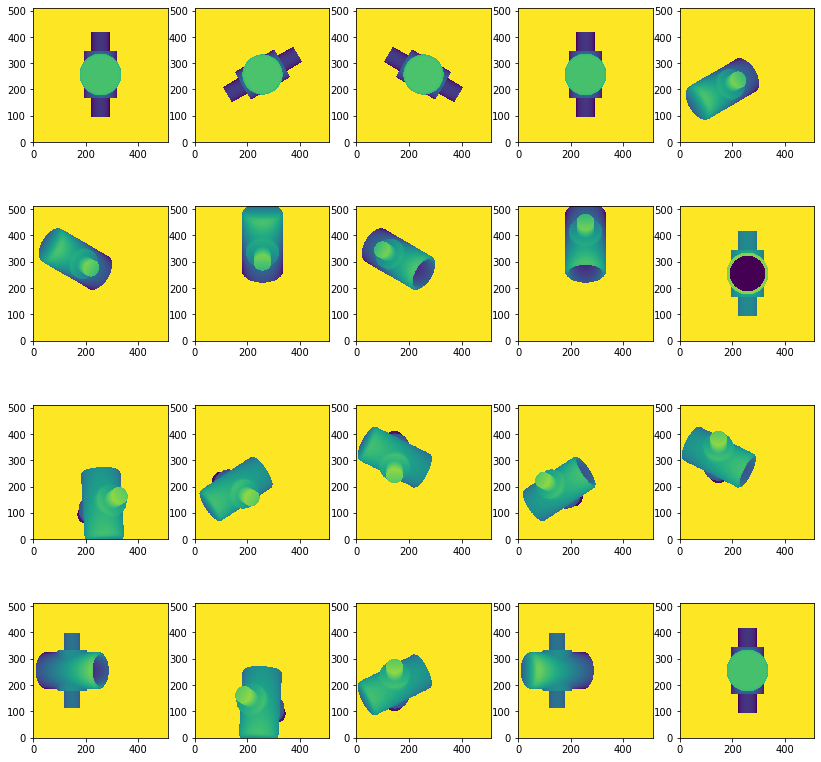

In [104]:
visualize_renders(renders)

In [109]:
def scatter_points(ax, mesh, vertex_indices, inverse_indices=True, image_height=512, image_width=512):    
#     ortho_scale = mesh.scale + ortho_scale_eps
    
#     mask = np.full((mesh.vertices.shape[0],), inverse_indices, dtype=np.bool)
#     mask[vertex_indices] = not inverse_indices
    
#     points = np.vstack((-mesh.vertices[mask][:, 1], -mesh.vertices[mask][:, 0])).T
#     scaled_points = (points + ortho_scale / 2) / ortho_scale * image_height
    
#     ax.scatter(scaled_points[:, 0], scaled_points[:, 1])

    ortho_scale = mesh.scale + ortho_scale_eps

    mask = np.full((mesh.vertices.shape[0],), False, dtype=np.bool)
    mask[vertex_indices] = True
    
    points = np.vstack((-mesh.vertices[mask][:, 1], -mesh.vertices[mask][:, 0])).T
    scaled_points = (points + ortho_scale / 2) / ortho_scale * image_height
    ax.scatter(scaled_points[:, 0], scaled_points[:, 1])

In [111]:
out_of_view[16]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

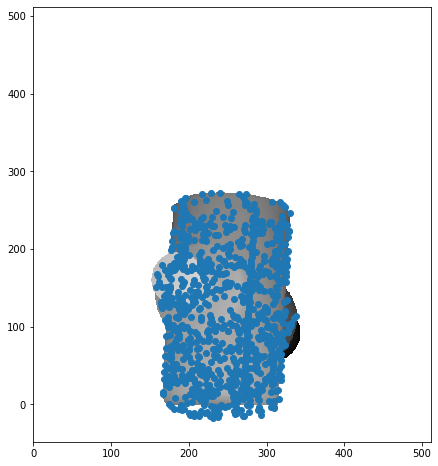

In [110]:
f, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.imshow(renders[16], origin='lower', cmap='gray')
scatter_points(axs, transform_mesh(mesh, **poses[16]), out_of_view[16], False)

In [79]:
def visualize_points(mesh, poses, visible_vertices, rows=4, inverse_indices=False):
    rows = 4
    f, axs = plt.subplots(rows, len(poses) // rows, figsize=(14, 14))

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(renders[i], origin='lower', cmap='gray')
        scatter_points(ax, transform_mesh(mesh, **poses[i]), visible_vertices[i], inverse_indices=inverse_indices) 
#         scatter_points(ax, transform_mesh(mesh, **poses[i]), np.arange(300), inverse_indices=inverse_indices) 

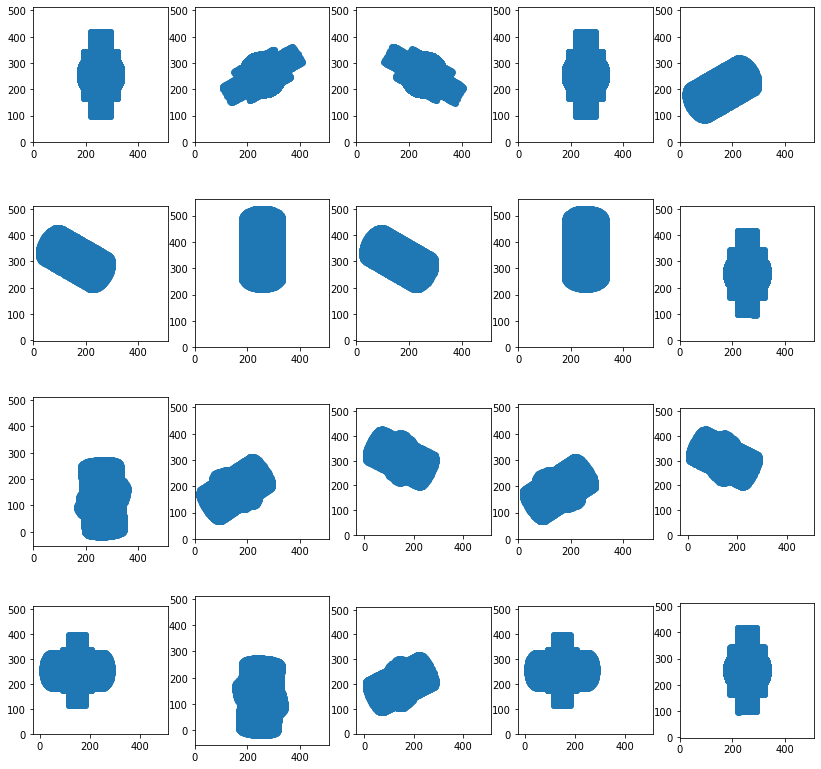

In [80]:
visualize_points(mesh, poses, visible_vertices, inverse_indices=False)

In [60]:
visible_vertices[16]

array([  927,   932,   938, ..., 20613, 20614, 20620])

In [65]:
visible_vertices

[array([    4,     5,     7, ..., 20614, 20618, 20620]),
 array([    4,     5,     7, ..., 20613, 20618, 20620]),
 array([    4,     5,     7, ..., 20614, 20618, 20620]),
 array([    4,     5,     7, ..., 20614, 20618, 20620]),
 array([    4,    10,    11, ..., 20612, 20613, 20620]),
 array([    4,    10,    11, ..., 20612, 20613, 20620]),
 array([  366,   369,   371, ..., 20612, 20613, 20620]),
 array([    0,     1,     2, ..., 20613, 20615, 20616]),
 array([  342,   347,   352, ..., 20613, 20615, 20616]),
 array([    0,     1,     2, ..., 20614, 20615, 20618]),
 array([  925,   927,   932, ..., 20613, 20618, 20620]),
 array([    0,     1,    10, ..., 20613, 20618, 20620]),
 array([    0,     1,    10, ..., 20613, 20618, 20620]),
 array([    1,     2,     3, ..., 20614, 20615, 20616]),
 array([    1,     2,     3, ..., 20614, 20615, 20616]),
 array([    1,     2,     3, ..., 20608, 20614, 20615]),
 array([  927,   932,   938, ..., 20613, 20614, 20620]),
 array([    2,     3,     4, ..